In [1]:
import math
import glob

import matplotlib.pyplot as plt
import torchaudio
import soundfile as sf
 
from fastai_audio.audio import *

from fastai.vision import *

## Creating spectrograms using Torchaudio

Internally, this code is similar to how fastai_audio is generating spectrograms. I included this here to experiment on params for spectrogram generation.

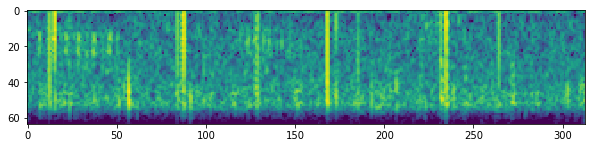

In [2]:
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, MFCC

sig, sr = torchaudio.load(
    "output/damselfish/40.wav",
)

mel = MelSpectrogram(
    f_min=200.0,
    f_max=1000.0,
    hop_length=32,
    n_fft=128,
    n_mels=64,
    pad=0,
    win_length=None
)(sig)

mel = AmplitudeToDB(top_db=50)(mel)
mel = mel.detach()

plt.figure(figsize=(10,13))
p = plt.imshow(mel[0,:,:].detach().numpy())

## Model training at long last

Now that we have everything we need, we can start training a model.
In this next cell, we'll set up the parameters we want to use for generating Spectrograms with our `SpectrogramConfig()`.

These are the default parameters for `SpectrogramConfig`:

    f_min: float = 0.0
    f_max: float = 22050.0
    hop_length: int = 256
    n_fft: int = 2560
    n_mels: int = 128
    pad: int = 0
    to_db_scale: bool = True
    top_db: int = 100
    win_length: int = None
    n_mfcc: int = 20


These parameters can be overriden when creating a new config like so:

`SpectrogramConfig(n_mels=256, top_db=60)`

At the end of this cell, we create our `AudioList`. It will configure a category for each folder in `/tmp/output`, (we have two, `damselfish` and `noise`) and split those samples up into training and validation sets with a random split.

If you have trained the model, and want to change some parameters again, you should change values in this cell and then run this and the subsequent cells again.

Some more information about how these parameters are used can be found in the torchaudio documentation here: [pytorch documentation](https://pytorch.org/audio/transforms.html)

In [3]:
# Set a seed for reproducability
torch.manual_seed(0)

from fastai_audio.audio import SpectrogramConfig, AudioConfig

path = Path("output/")

sg_cfg = SpectrogramConfig(
    f_min=200.0,
    f_max=1000.0,
    hop_length=32,
    n_fft=128,
    n_mels=64,
    pad=0,
    win_length=None
)

config = AudioConfig(
    use_spectro=True,
    #delta=True,
    sg_cfg=sg_cfg,
)

al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()

## Transforms

The next cell sets up optional transforms for our spectrograms. These are more advanced techniques that come from some work at [Google](https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html).

I am upscaling the size of our spectrograms from their defaults, but so far, I haven't had any luck masking freqencies and time. 

------------------------------------------------------------
File: output/damselfish/20150616-003548-1142.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


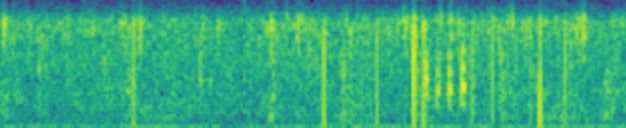

------------------------------------------------------------
File: output/damselfish/60.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


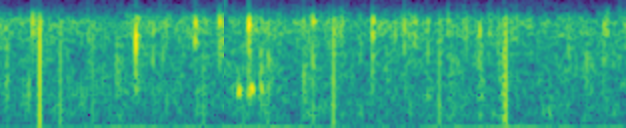

------------------------------------------------------------
File: output/damselfish/125.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


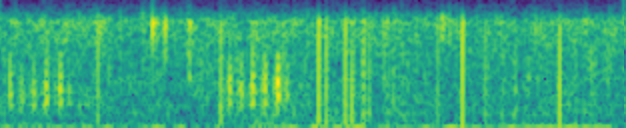

------------------------------------------------------------
File: output/damselfish/20150818-011638-1948.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


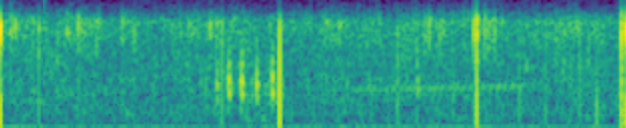

------------------------------------------------------------
File: output/damselfish/18.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: damselfish


Channel 0.0 (128x626):


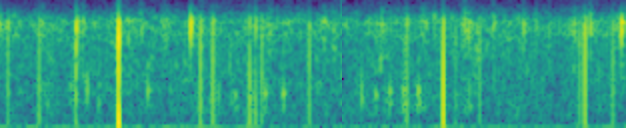

In [4]:
tfms = None
#tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
tfms = get_spectro_transforms(
    size=(128, 626), # Upscale the spectrograms from 64x313
    mask_frequency=False, # Don't mask frequencies
    mask_time=False # Don't mask time
)
db = al.transform(tfms).databunch(bs=10)
db.show_batch(5)

## Create the learner and find a learning rate

In this cell, we create our learner, select an architecture and find a learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


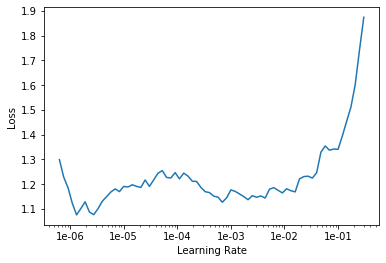

In [8]:
learn = audio_learner(db, base_arch=models.resnet50, wd=0.1, metrics=[accuracy, Precision(), Recall()])
learn.lr_find()
learn.recorder.plot()

## Train the model

After selecting a learning rate, we can begin to train our model. During each epoch, you will see stats like:

    epoch 	train_loss 	valid_loss 	accuracy 	time
      0 	  0.823691 	  1.401638 	  0.593750 	00:07

In the [fast.ai video](https://youtu.be/ccMHJeQU4Qw?t=2936), Jeremy mentions that you never want to see a training loss that is higher than the valid loss. If you do, you should increase your learning rate, or increase the number of epochs. These are the two parameters that are passed to `fit_one_cycle` below.


In [9]:
learn.fit_one_cycle(20, slice(2e-2))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.096697,1.005433,0.574468,0.666667,0.446602,00:09
1,0.989118,0.942744,0.622340,0.625000,0.776699,00:09
2,1.057404,0.789847,0.680851,0.708738,0.708738,00:09
3,0.825395,0.871773,0.622340,0.820000,0.398058,00:09
4,0.644852,0.307132,0.893617,0.848740,0.980583,00:09
5,0.515716,0.730715,0.765957,0.873418,0.669903,00:09
6,0.424630,0.495200,0.696809,0.979167,0.456311,00:09
7,0.308545,0.948319,0.627660,0.945946,0.339806,00:09
8,0.274363,0.245864,0.888298,0.859649,0.951456,00:09
9,0.282391,0.250843,0.909574,0.858333,1.000000,00:09


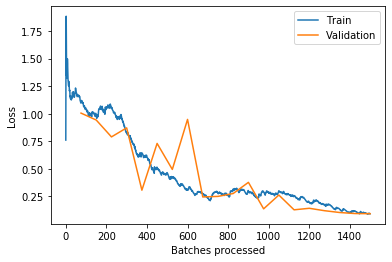

In [10]:
learn.recorder.plot_losses()

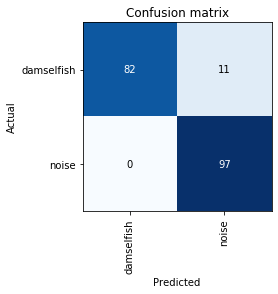

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.save("weight_decay_more_data")